In [1187]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## **Overview**


In this project, I aim to analyze the impact of mobility restrictions on COVID-19 fatalities using the Synthetic Interventions method. The analysis focuses on:

1) Comparing different levels of mobility restrictions (Low, Moderate, Severe);
2) Estimating counterfactual based on severe restrictions;
3) Try to visualize and understand how different intervention levels might have affected mortality rates.

The data comes from two main sources:
- **Johns Hopkins COVID-19** database for mortality data
- **Google Mobility Reports** for restriction levels

Using the Synthetic Interventions approach, we can estimate what would have happened if countries with moderate restrictions had implemented more severe mobility measures. This method also represents a powerful way to evaluate policy effectiveness in public health interventions.

For the purpose of this project, I'll focus the analysis on **Brazil.**

## **Data Processing:**

The data comes from Johns Hopkins (https://github.com/CSSEGISandData/COVID-19), which provides information on cumulative COVID-19 related deaths, and is already preprocessed to show daily values.

### **Data Loading:**

In [1188]:
covid_df = pd.read_csv("./data_global_data.csv")
covid_df

,country,date,deaths,daily_deaths
0,Afghanistan,01/23/20,0,0.0
1,Afghanistan,01/24/20,0,0.0
2,Afghanistan,01/25/20,0,0.0
3,Afghanistan,01/26/20,0,0.0
4,Afghanistan,01/27/20,0,0.0
...,...,...,...,...
218281,Zimbabwe,01/08/23,5637,0.0
218282,Zimbabwe,01/09/23,5637,0.0
218283,Zimbabwe,01/10/23,5637,0.0
218284,Zimbabwe,01/11/23,5637,0.0


In [1189]:
# Convert date column to datetime especificando o formato
covid_df['date'] = pd.to_datetime(covid_df['date'], format='%m/%d/%y')

# Check if there are missing values
print("\nMissing Values:")
print(covid_df.isnull().sum())

# Check if there are duplicate entries
print("\nNumber of Duplicate Entries:", covid_df.duplicated().sum())

# Check how many countries are in the dataset
print("\nNumber of Unique Countries:", covid_df['country'].nunique())



Missing Values:
country         0
date            0
deaths          0
daily_deaths    0
dtype: int64

Number of Duplicate Entries: 0

Number of Unique Countries: 201


In [1190]:
covid_df.loc[covid_df['country'] == 'Brazil'] ## Check the indices for which we have Brazil entries

,country,date,deaths,daily_deaths
26064,Brazil,2020-01-23,0,0.0
26065,Brazil,2020-01-24,0,0.0
26066,Brazil,2020-01-25,0,0.0
26067,Brazil,2020-01-26,0,0.0
26068,Brazil,2020-01-27,0,0.0
...,...,...,...,...
27145,Brazil,2023-01-08,694779,0.0
27146,Brazil,2023-01-09,694779,0.0
27147,Brazil,2023-01-10,694985,206.0
27148,Brazil,2023-01-11,695088,103.0


In [1191]:
covid_df.loc[26064:27149]

,country,date,deaths,daily_deaths
26064,Brazil,2020-01-23,0,0.0
26065,Brazil,2020-01-24,0,0.0
26066,Brazil,2020-01-25,0,0.0
26067,Brazil,2020-01-26,0,0.0
26068,Brazil,2020-01-27,0,0.0
...,...,...,...,...
27145,Brazil,2023-01-08,694779,0.0
27146,Brazil,2023-01-09,694779,0.0
27147,Brazil,2023-01-10,694985,206.0
27148,Brazil,2023-01-11,695088,103.0


###  **Defining Time Steps:**

Most epidemiological models suggest that, at the beginning of an epidemic process when the number of infected is far less than the population size, the dynamics of infection don't depend much on the population size itself. 

In this sense, we establish the time stamps of the data relative to the point at which 80 cumulative deaths are observed for every country. That is, the timestamp for the first date after which there are 80 cumulative deaths is 0. 

Then, we define timestamps -20 to -1 as a "pre-intervention" period and timestamps 0 to 20 as a "post-intervention" period.

In [1192]:
## Define the number of deaths that will be used to define the pre-intervention period
pre_intervention_death_count = 80 

## Create a column to identify the post-intervention period
covid_df['post-intervention'] = covid_df['deaths'] >= pre_intervention_death_count 

covid_df.head()

,country,date,deaths,daily_deaths,post-intervention
0,Afghanistan,2020-01-23,0,0.0,False
1,Afghanistan,2020-01-24,0,0.0,False
2,Afghanistan,2020-01-25,0,0.0,False
3,Afghanistan,2020-01-26,0,0.0,False
4,Afghanistan,2020-01-27,0,0.0,False


In [1193]:
# Get post-intervention date for each country
t0_date = covid_df[covid_df['post-intervention']].groupby('country')['date'].min()
t0_date

country
Afghanistan          2020-05-06
Albania              2020-07-07
Algeria              2020-04-02
Andorra              2020-12-18
Angola               2020-08-11
                        ...    
Vietnam              2021-06-29
West Bank and Gaza   2020-07-29
Yemen                2020-05-31
Zambia               2020-07-17
Zimbabwe             2020-08-03
Name: date, Length: 179, dtype: datetime64[ns]

In [1194]:
# Create a column with the t0 date for each country
covid_df = pd.merge(covid_df, t0_date.reset_index(), on='country', how='left')\
                .rename(columns={'date_x': 'date', 'date_y': 't0_date'})

# Extract the difference between the date of the current observation and the t = 0 date
covid_df['t'] = (covid_df['date'] - covid_df['t0_date']).dt.days

In [1195]:
# Filter the dates on where t is between -20 and 20
covid_df = covid_df[(covid_df['t'] >= -20) & (covid_df['t'] <= 20)]

covid_df.head()

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0


### **Assigning Mobility Interventions**


Here we'll assign mobility interventions for each country by using Google mobility data (https://www.google.com/covid19/mobility/). The Google data is reported relative to pre-2020 mobility, such that a score of -10 means that on that date, the mobility of a country's population is 10% less than pre-2020 levels. 

Then, we bucket countries as having three possible interventions:

| Intervention Type     | Reduction in Mobility (Compared to Jan. 2020 Baseline) |
|:----       |    :----:   | 
| Low    | <10%       |
| Moderate   | 10-40%        |
| Severe  | >40%        |

    
We'll measure the mobility reduction in the time period between $t = -20$ to $t = -1$, as we anticipate a delay between mobility reductions and reported case counts. Hence, we assume that it takes about 20 days for a reduction in mobility to impact future case counts.

In [1196]:
mobility_df = pd.read_csv("./data_global_mobility_report.csv").rename(columns={'country_region': 'country'})

In [1197]:
mobility_df[mobility_df['country'] == 'Brazil'] ## Find the indices for Brazil

,country_region_code,country,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
17436,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-15,5.0,4.0,-5.0,8.0,6.0,0.0
17437,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-16,2.0,3.0,-13.0,3.0,0.0,1.0
17438,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-17,-2.0,0.0,-12.0,9.0,19.0,-1.0
17439,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-18,-3.0,-1.0,-11.0,9.0,15.0,-1.0
17440,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-19,-1.0,-2.0,-5.0,8.0,14.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18405,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2022-10-11,16.0,62.0,16.0,11.0,33.0,0.0
18406,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2022-10-12,0.0,33.0,64.0,-35.0,-52.0,14.0
18407,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2022-10-13,4.0,55.0,24.0,8.0,34.0,1.0
18408,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2022-10-14,6.0,56.0,17.0,8.0,35.0,2.0


Here we focus on data from retail and recreation, since one of our main concerns here is how shutting down the economy affects COVID-19 fatalities.

In [1198]:
mobility_df = pd.read_csv("./data_global_mobility_report.csv").rename(columns={'country_region': 'country'})
# restrict only to country wide data
mobility_df = mobility_df[mobility_df['sub_region_1'].isnull() & \
                          mobility_df['sub_region_2'].isnull() & \
                          mobility_df['metro_area'].isnull()]

mobility_df['date'] = pd.to_datetime(mobility_df['date']) ## Convert the dates into datetime objects
mobility_df[mobility_df['country'] == 'Brazil'][['country', 'date', 'retail_and_recreation_percent_change_from_baseline']] ## looking at retail and recreation percent change for Brazil

,country,date,retail_and_recreation_percent_change_from_baseline
17436,Brazil,2020-02-15,5.0
17437,Brazil,2020-02-16,2.0
17438,Brazil,2020-02-17,-2.0
17439,Brazil,2020-02-18,-3.0
17440,Brazil,2020-02-19,-1.0
...,...,...,...
18405,Brazil,2022-10-11,16.0
18406,Brazil,2022-10-12,0.0
18407,Brazil,2022-10-13,4.0
18408,Brazil,2022-10-14,6.0


In [1199]:
# get mobility scores specifically on the dates that are reported in the covid_df when t is between -20 and -1
mobility_df = pd.merge(mobility_df, covid_df[covid_df['t'] < 0], on=['country', 'date'], how='right')

# now the retail scores are only on the dates we care about for each country
mobility_df[['country', 'date', 't', 'retail_and_recreation_percent_change_from_baseline']].head()

,country,date,t,retail_and_recreation_percent_change_from_baseline
0,Afghanistan,2020-04-16,-20.0,-46.0
1,Afghanistan,2020-04-17,-19.0,-41.0
2,Afghanistan,2020-04-18,-18.0,-43.0
3,Afghanistan,2020-04-19,-17.0,-43.0
4,Afghanistan,2020-04-20,-16.0,-42.0


In [1200]:
# now we group countries based on their scores
country_mobility_scores = \
        mobility_df.groupby('country')['retail_and_recreation_percent_change_from_baseline'].mean()

low_countries = []
moderate_countries = []
severe_countries = []

for country, score in country_mobility_scores.items():
    if(not pd.isnull(score)):
        if(score > -10):
            low_countries.append(country)
        elif(score < -40):
            severe_countries.append(country)
        else:
            moderate_countries.append(country)

In [1201]:
# Check the number of countries in each group
len(low_countries), len(moderate_countries), len(severe_countries)

(22, 50, 50)

In [1202]:
# Checking Brazil's mobility score
brazil_score = country_mobility_scores.get('Brazil', None)
brazil_score

-26.9

## **Exploratory Data Analysis:**

### **Descriptive Analysis:**

Now that we have defined the categories, we can conduct a descriptive analysis by group:

In [1203]:
# Creating dataframes for each mobility intervention category
df = pd.read_csv("./data_global_data.csv")
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
low_df = df[df['country'].isin(low_countries)]
moderate_df = df[df['country'].isin(moderate_countries)]
severe_df = df[df['country'].isin(severe_countries)]  

In [1204]:
low_df

,country,date,deaths,daily_deaths
6516,Antigua and Barbuda,2020-01-23,0,0.0
6517,Antigua and Barbuda,2020-01-24,0,0.0
6518,Antigua and Barbuda,2020-01-25,0,0.0
6519,Antigua and Barbuda,2020-01-26,0,0.0
6520,Antigua and Barbuda,2020-01-27,0,0.0
...,...,...,...,...
217195,Zambia,2023-01-08,4028,0.0
217196,Zambia,2023-01-09,4030,2.0
217197,Zambia,2023-01-10,4030,0.0
217198,Zambia,2023-01-11,4031,1.0


In [1205]:
low_df[['deaths', 'daily_deaths']].describe()

,deaths,daily_deaths
count,23892.000000,23892.000000
mean,20888.985937,33.704085
std,46672.570734,116.056283
min,0.000000,0.000000
25%,52.000000,0.000000
50%,651.000000,0.000000
75%,7651.000000,6.000000
max,215636.000000,2291.000000


In [1206]:
moderate_df[['deaths', 'daily_deaths']].describe()


,deaths,daily_deaths
count,54300.00000,54300.000000
mean,24462.70744,41.239484
std,83828.86868,176.434800
min,0.00000,0.000000
25%,162.00000,0.000000
50%,1584.00000,1.000000
75%,8942.00000,9.000000
max,695236.00000,4272.000000


In [1207]:
severe_df[['deaths', 'daily_deaths']].describe()

,deaths,daily_deaths
count,54300.000000,54300.000000
mean,25131.893941,41.114715
std,60567.585969,169.729104
min,0.000000,0.000000
25%,1230.000000,0.000000
50%,6937.000000,5.000000
75%,21448.750000,27.000000
max,530725.000000,11447.000000


Observing how the distribution of deaths across countries looks like:

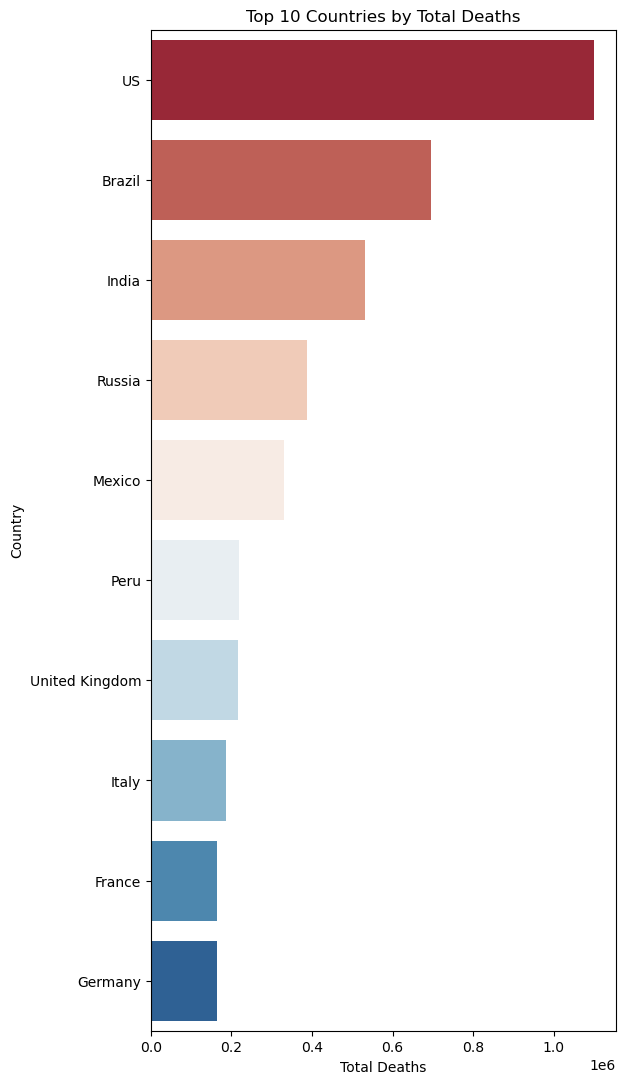

In [1208]:
# Total deaths by country
country_deaths = df.groupby('country')['deaths'].max().reset_index()
country_deaths = country_deaths.sort_values(by='deaths', ascending=False)

plt.figure(figsize=(6, 13))
sns.barplot(data=country_deaths.head(10), x='deaths', hue='country', y='country',
           palette='RdBu', legend=False)  
plt.title('Top 10 Countries by Total Deaths')
plt.xlabel('Total Deaths') 
plt.ylabel('Country')
plt.show()

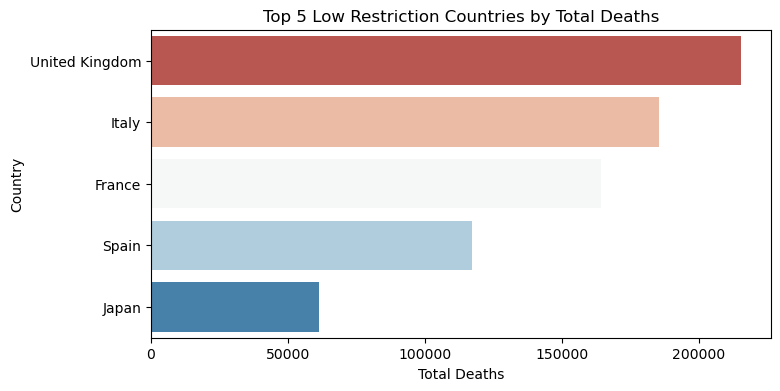

In [1209]:
# Total deaths by low restriction countries
low_deaths = low_df.groupby('country')['deaths'].max().reset_index()
low_deaths = low_deaths.sort_values(by='deaths', ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(data=low_deaths.head(5), x='deaths', hue='country', y='country',
           palette='RdBu', legend=False) 
plt.title('Top 5 Low Restriction Countries by Total Deaths')
plt.xlabel('Total Deaths')
plt.ylabel('Country')
plt.show()

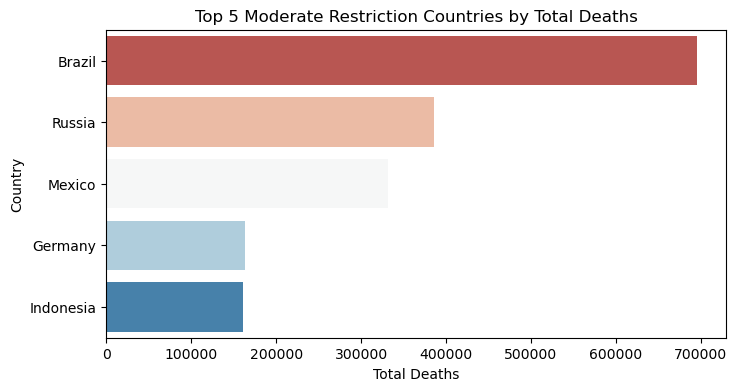

In [1210]:
# Total deaths by moderate restriction countries
moderate_deaths = moderate_df.groupby('country')['deaths'].max().reset_index()
moderate_deaths = moderate_deaths.sort_values(by='deaths', ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(data=moderate_deaths.head(5), x='deaths', hue='country', y='country',
           palette='RdBu', legend=False) 
plt.title('Top 5 Moderate Restriction Countries by Total Deaths')
plt.xlabel('Total Deaths')
plt.ylabel('Country')
plt.show()

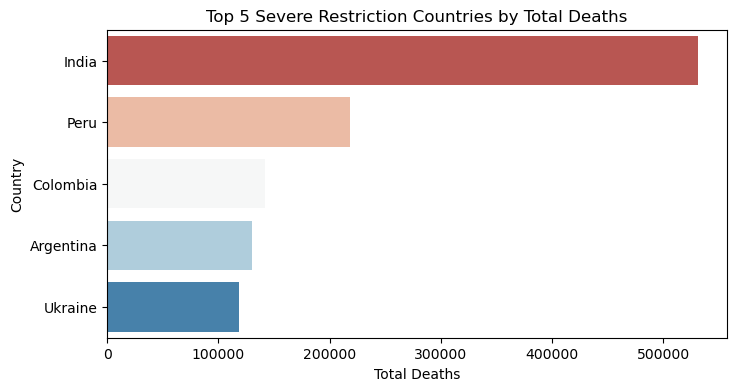

In [1211]:
# Total deaths by severe restriction countries
severe_deaths = severe_df.groupby('country')['deaths'].max().reset_index()
severe_deaths = severe_deaths.sort_values(by='deaths', ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(data=severe_deaths.head(5), x='deaths', hue='country', y='country',
           palette='RdBu', legend=False) 
plt.title('Top 5 Severe Restriction Countries by Total Deaths')
plt.xlabel('Total Deaths')
plt.ylabel('Country')
plt.show()

### **Distribution of daily deaths across top 5 countries (for each group):**

In [1212]:
# Filter the DataFrame by each restriction group
df_low = covid_df[covid_df['country'].isin(low_countries)]
df_moderate = covid_df[covid_df['country'].isin(moderate_countries)]
df_severe = covid_df[covid_df['country'].isin(severe_countries)]

def get_top5_countries(df):
    deaths_by_country = df.groupby('country')['deaths'].sum().reset_index()
    top5 = deaths_by_country.sort_values('deaths', ascending=False).head(5)['country'].tolist()
    return top5

top5_low = get_top5_countries(df_low)
top5_moderate = get_top5_countries(df_moderate)
top5_severe = get_top5_countries(df_severe)

# Filter each DataFrame again to only include the Top 5 countries

low_top5_df = df_low[df_low['country'].isin(top5_low)]
moderate_top5_df = df_moderate[df_moderate['country'].isin(top5_moderate)]
severe_top5_df = df_severe[df_severe['country'].isin(top5_severe)]

In [1213]:
fig_low = px.box(
    low_top5_df,
    x='country',
    y='daily_deaths',
    points='all',
    title="Top 5 Low Restriction Countries by Deaths (Boxplot)",
    color_discrete_sequence=['#3381ff']
)
fig_low.update_layout(
    template='plotly_white',
    plot_bgcolor='white',
    title_font_size=13.2,
    font=dict(size=8.8),
    xaxis=dict(tickfont=dict(size=8.8)),
    yaxis=dict(tickfont=dict(size=8.8)),
    width=600
)
fig_low.update_traces(
    marker=dict(size=6, opacity=0.4, line=dict(width=1, color='black'))
)
fig_low.for_each_trace(lambda t: t.update(line=dict(width=0.65)))
fig_low.show()

These “low restriction” countries reveal a significant range in daily deaths, underscoring that relaxed policies alone do not uniformly translate into low fatality rates. 

Spain and the United Kingdom, for instance, show larger spikes (visible in the tall outliers), suggesting periods when daily fatalities surged well beyond the median. 

In contrast, Japan’s boxplot remains relatively compressed, pointing to a more stable pattern of daily deaths despite similarly low restriction levels. This divergence implies that factors like population density, healthcare infrastructure, and timing of virus surges can be as influential—if not more so—than policy strictness alone. 

---

In [1214]:
# =========================================================
# Seção 2: Boxplot para Moderate Restriction Countries
# =========================================================
fig_moderate = px.box(
    moderate_top5_df,
    x='country',
    y='daily_deaths',
    points='all',
    title="Top 5 Moderate Restriction Countries by Deaths (Boxplot)",
    color_discrete_sequence=['#3381ff']
)
fig_moderate.update_layout(
    template='plotly_white',
    plot_bgcolor='white',
    title_font_size=13.2,
    font=dict(size=8.8),
    xaxis=dict(tickfont=dict(size=8.8)),
    yaxis=dict(tickfont=dict(size=8.8)),
    width=600
)
fig_moderate.update_traces(
    marker=dict(size=6, opacity=0.4, line=dict(width=1, color='black'))
)
fig_moderate.for_each_trace(lambda t: t.update(line=dict(width=0.65)))
fig_moderate.show()

Although these countries share “moderate restriction” classification, their daily death patterns differ markedly. 

Brazil’s distribution extends far beyond those of the other nations, with spikes occasionally surpassing 4,000 deaths in a single day, suggesting intense surges despite not being in the “severe” category. 

Meanwhile, Germany’s boxplot shows a somewhat higher median than Indonesia, Mexico, and Russia, yet still falls well below Brazil’s peaks. The contrast underscores that policy stringency alone does not fully account for the scale or timing of outbreaks; factors like population demographics, healthcare capacity, and the timing of viral waves appear equally—if not more—consequential in shaping daily fatality trajectories. 

---


In [1215]:
fig_severe = px.box(
    severe_top5_df,
    x='country',
    y='daily_deaths',
    points='all',
    title="Top 5 Severe Restriction Countries by Deaths (Boxplot)",
    color_discrete_sequence=['#3381ff']
)
fig_severe.update_layout(
    template='plotly_white',
    plot_bgcolor='white',
    title_font_size=13.2,
    font=dict(size=8.8),
    xaxis=dict(tickfont=dict(size=8.8)),
    yaxis=dict(tickfont=dict(size=8.8)),
    width=600
)
fig_severe.update_traces(
    marker=dict(size=6, opacity=0.4, line=dict(width=1, color='black'))
)
fig_severe.for_each_trace(lambda t: t.update(line=dict(width=0.65)))
fig_severe.show()

Among the severe countries, India experienced very high daily death counts—often exceeding 6,000—which strongly suggests that a massive population and limited healthcare resources overwhelmed strict measures. 

Peru and Poland recorded notably lower peaks, indicating that timely interventions or favorable local conditions effectively moderated the impact. These observations suggest that while stringent policies are essential, their effectiveness ultimately depends on a complex interplay of demographic, infrastructural, and contextual factors.

---



### **Trend Analysis:**


Analyzing the death patterns over time can provide valuable insights into the pandemic's progression within each category.

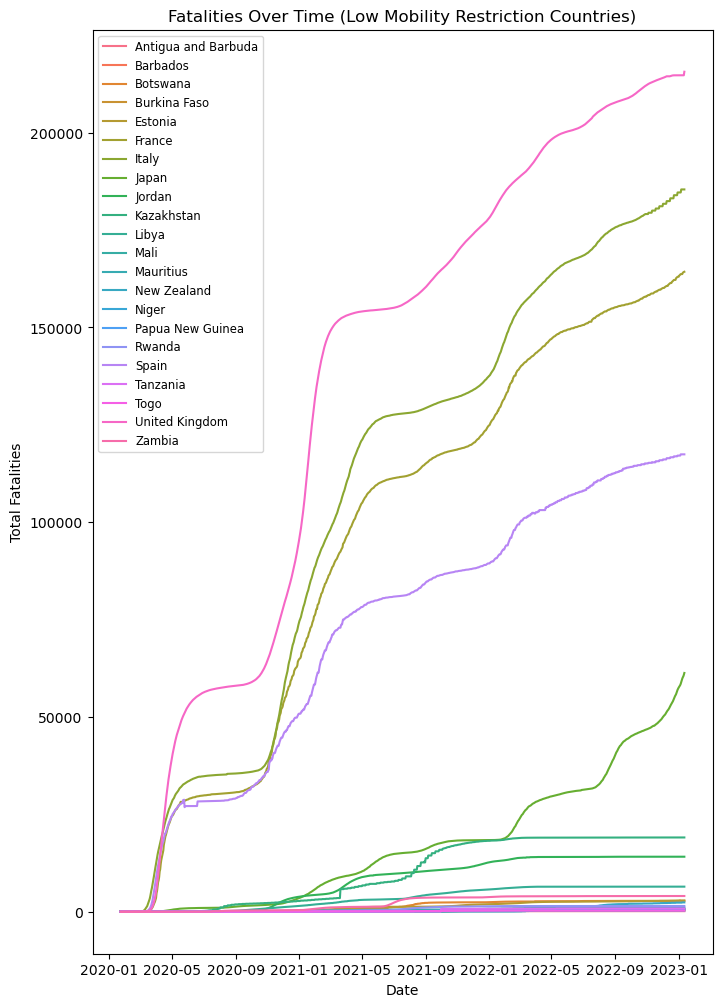

In [1216]:
plt.figure(figsize=(8, 12))
sns.lineplot(data=low_df, x='date', y='deaths', hue='country')
plt.title('Fatalities Over Time (Low Mobility Restriction Countries)')
plt.xlabel('Date')
plt.ylabel('Total Fatalities')
plt.legend(loc='upper left', fontsize='small', ncol=1)
plt.show()

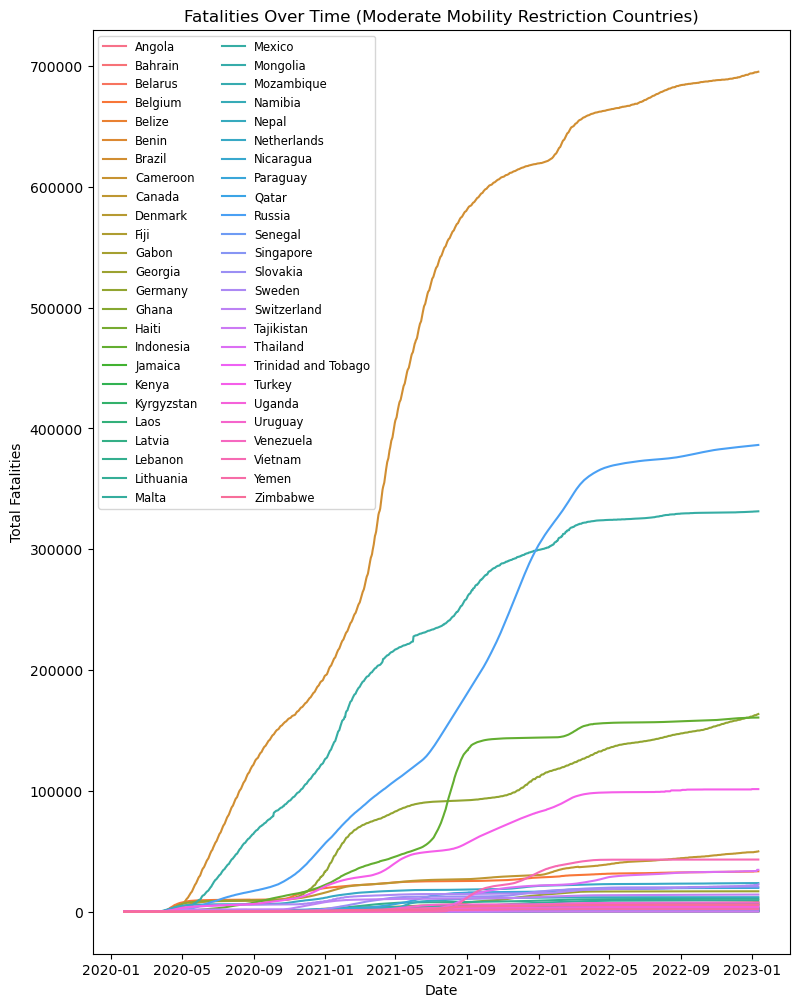

In [1217]:
plt.figure(figsize=(9, 12))
sns.lineplot(data=moderate_df, x='date', y='deaths', hue='country')
plt.title('Fatalities Over Time (Moderate Mobility Restriction Countries)')
plt.xlabel('Date')
plt.ylabel('Total Fatalities')
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.show()

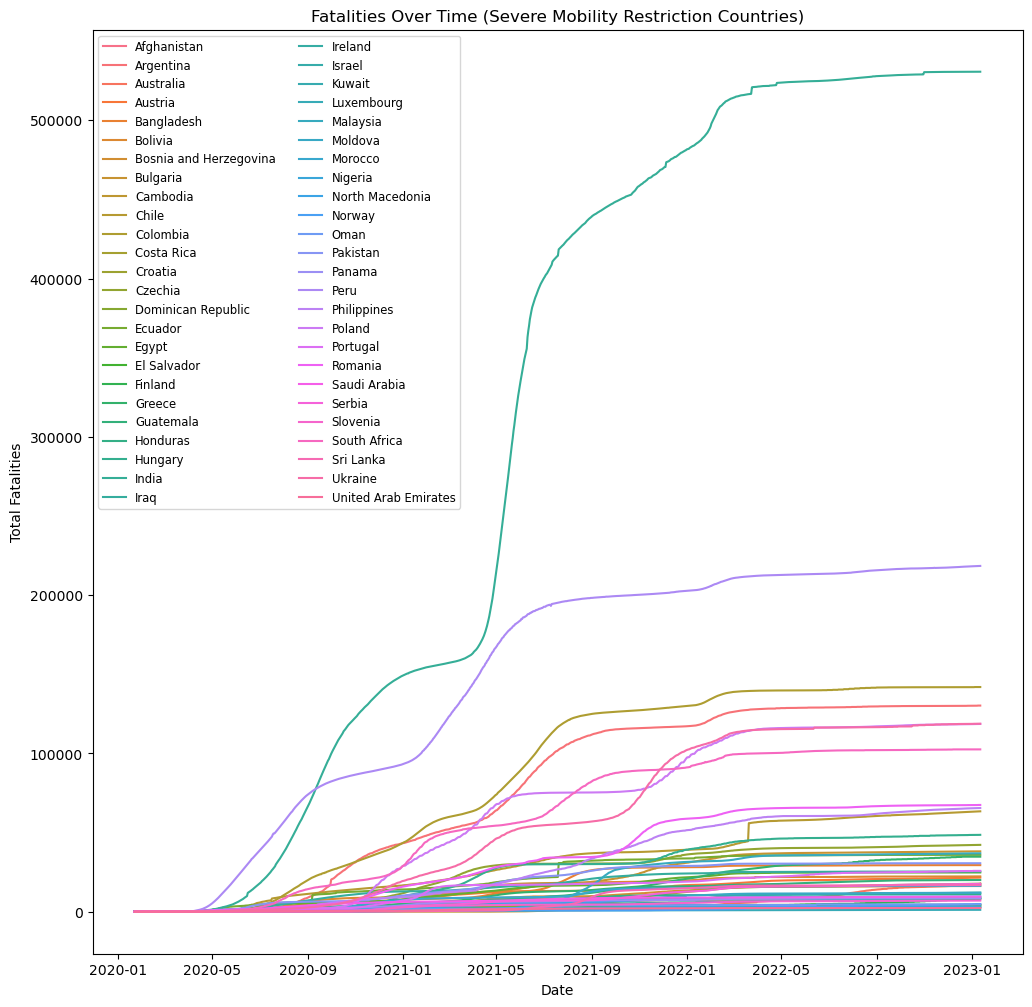

In [1218]:
plt.figure(figsize=(12, 12))
sns.lineplot(data=severe_df, x='date', y='deaths', hue='country')
plt.title('Fatalities Over Time (Severe Mobility Restriction Countries)')
plt.xlabel('Date')
plt.ylabel('Total Fatalities')
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.show()

When comparing all three groups—low, moderate, and severe mobility restriction countries—it's clear that reported fatality trends vary dramatically, even within the same category. 

In some cases (e.g., Western European nations), steep and sustained climbs in fatalities suggest either larger outbreaks, more accurate reporting, or both. Meanwhile, several African and Asian countries show relatively flat lines, which could indicate genuinely low death tolls or, more likely, limited testing and inconsistent data collection. 

This discrepancy highlights how incomplete information can mask the true severity of the pandemic, making direct comparisons across nations and restriction categories challenging. Even so, the stark contrasts in these curves emphasize that policy strictness alone does not fully account for a country's pandemic trajectory; differences in healthcare capacity, population density, and data reliability also play key roles.

---


## **Reshaping the Data**

Now we need to reshape the dataset into a nice matrix form in order of modelling synthetic interventions

In [1219]:
covid_df['date'] = pd.to_datetime(covid_df['date'], format='%m/%d/%y') ## Converting the dates into a datetime object in Pandas

covid_df.head()

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0


In [1220]:
covid_df = covid_df[['country', 'daily_deaths', 't']]\
        .pivot(index='country', columns='t', values='daily_deaths').reset_index()

covid_df.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
1,Albania,1.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2.0,...,4.0,1.0,1.0,4.0,3.0,3.0,5.0,6.0,4.0,6.0
2,Algeria,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,4.0,...,20.0,13.0,10.0,12.0,16.0,3.0,8.0,9.0,8.0,10.0
3,Andorra,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0


# **Synthetic Interventions**

Now we'll apply the "Synthetic Interventions" method to estimate the severe counterfactual outcome for COVID-19 fatalities in Brazil.

From our data, we know that Brazil had moderated mobility restrictions (around 27% reduction compared to pre-2020 levels) by the time of the 80th national death:

In [1221]:
country_of_interest = "Brazil"
print(country_of_interest in moderate_countries) # confirm that the Brazil had moderate intervention

True


## **Isolate the data of countries which did enact a severe mobility restriction**

In [1222]:
covid_df

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
1,Albania,1.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2.0,...,4.0,1.0,1.0,4.0,3.0,3.0,5.0,6.0,4.0,6.0
2,Algeria,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,4.0,...,20.0,13.0,10.0,12.0,16.0,3.0,8.0,9.0,8.0,10.0
3,Andorra,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Vietnam,0.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,...,2.0,7.0,6.0,7.0,6.0,69.0,18.0,0.0,29.0,80.0
175,West Bank and Gaza,4.0,3.0,6.0,3.0,3.0,5.0,0.0,7.0,2.0,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,2.0,3.0,0.0
176,Yemen,1.0,1.0,2.0,0.0,3.0,3.0,2.0,0.0,8.0,...,7.0,3.0,21.0,4.0,44.0,6.0,30.0,4.0,3.0,3.0
177,Zambia,0.0,1.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,...,2.0,4.0,3.0,2.0,14.0,5.0,1.0,2.0,3.0,23.0


In [1223]:
severe_countries_ts = covid_df[covid_df['country'].isin(severe_countries)]
severe_countries_ts.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
6,Argentina,1.0,0.0,0.0,2.0,2.0,1.0,4.0,5.0,1.0,...,11.0,5.0,13.0,11.0,9.0,7.0,5.0,10.0,7.0,4.0
8,Australia,5.0,5.0,5.0,5.0,1.0,3.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,Austria,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,31.0,29.0,17.0,22.0,23.0,17.0,12.0,21.0,13.0,16.0
13,Bangladesh,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,3.0,...,8.0,5.0,2.0,5.0,2.0,5.0,1.0,3.0,13.0,7.0


## **Denoise the data**

Selecting $\tilde{r}$ for Synthetic Interventions

Here we need to check if the data in the pre-intervention period (where we assume all countries' time series obey a similar latent structure) is low rank, then see how many singular values are required to explain most of the variation in the data.

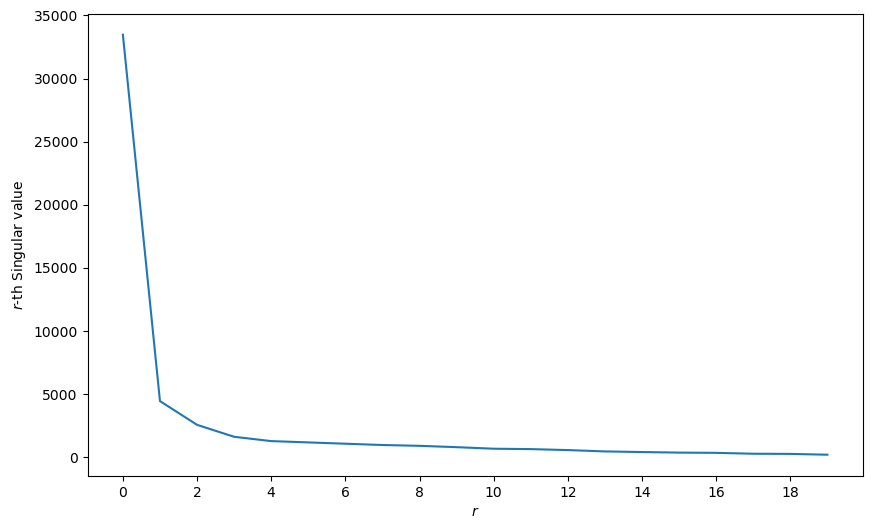

In [1224]:
u, s, vh = np.linalg.svd(covid_df.dropna().loc[:, -20:-1].to_numpy())
plt.figure(figsize=(10, 6))
plt.plot(np.power(s, 2))
#plt.semilogy()
plt.xlabel("$r$")
plt.ylabel("$r$-th Singular value")
plt.xticks(np.arange(0, 20, 2))
plt.show()

By analyzing the plot above, we can see that the data appears to have a low rank structure, which justifies the use of the Synthetic Interventions method.

Furthermore, there seems to be an elbow point around 3 or 4 -- either is justifiable in this case because the plot isn't completely clear between the two options.

Then, we stick to $\tilde{r}$ = 4 

In [1225]:
Y_pre = severe_countries_ts.loc[:, -20:-1].to_numpy() ## isolating the pre-intervention period

# Applying SVD to denoise the data
u, s, vh = np.linalg.svd(Y_pre)

r_tilde=4
smat = np.zeros((u.shape[0], vh.shape[0])) 
smat[:r_tilde, :r_tilde] = np.diag(s[:r_tilde]) ## creating truncated singular values matrix keeping only the values that preserve 90% of energy

Y_pre_tilde = u @ smat @ vh ## reconstructing the denoised matrix

## **Learn the pre-intervention model**

In [1226]:
import statsmodels.api as sm

# The dependent variable here is the pre-intervention time series observations from Brazil
brazil_pre = covid_df[covid_df['country'] == "Brazil"].loc[:, -20: -1].to_numpy().flatten()
dvs = brazil_pre
# We build the model with independent variables from the pre-intervention entries of the denoised matrix
ivs = Y_pre_tilde.T
model = sm.OLS(dvs, ivs)
reg = model.fit()

## **Estimate the post-intervention counterfactual**

In [1227]:
Y_post = severe_countries_ts.loc[:, 0:20].to_numpy() ## isolating the post-intervention period
severe_counterfactual_estimates = reg.predict(Y_post.T) ## estimating the severecounterfactual

# get true values for comparison
brazil_post = covid_df[covid_df['country'] == "Brazil"].loc[:, 0: 20].to_numpy().flatten()


## **Plotting the results**

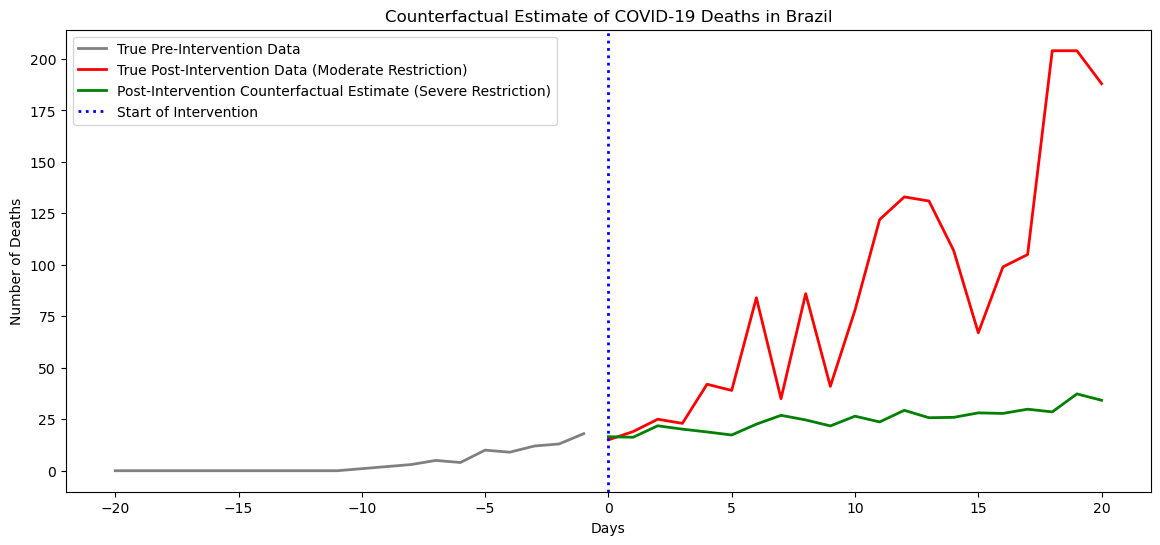

In [1228]:
plt.figure(figsize=(14, 6))

plt.plot(range(-20, 0), brazil_pre, 
         label="True Pre-Intervention Data", color='grey', linestyle='-', linewidth=2)

plt.plot(range(0, 21), brazil_post, 
         label="True Post-Intervention Data (Moderate Restriction)", color='red', linestyle='-', linewidth=2)

plt.plot(range(0, 21), severe_counterfactual_estimates, 
         label="Post-Intervention Counterfactual Estimate (Severe Restriction)", color='green', linestyle='-', linewidth=2)

plt.axvline(x=0, color='blue', linestyle=':', linewidth=2, label='Start of Intervention')

plt.xlabel('Days')
plt.ylabel('Number of Deaths')
plt.title('Counterfactual Estimate of COVID-19 Deaths in Brazil')
plt.legend()
plt.show()

## **Conclusions**

By comparing moderate and severe time series, we find that severe counterfactual has significantly fewer deaths than the true post-intervention data for Brazil (moderate mobility restriction).

This observation suggests that adopting severe interventions in mobility could have drastically reduced the number of COVID-19-related deaths in countries that were more flexible, such as Brazil.